<a href="https://colab.research.google.com/github/umarzafar11/Chatty/blob/main/X_ray_Bone_Fracture_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **X-Ray Bone Fracture Classification with CNNs**




This Colab notebook presents a deep learning-based approach for **classifying X-ray images of bone fractures** using **Convolutional Neural Networks (CNNs)**. The model is trained to differentiate between **Simple** and **Comminuted fractures** using the publicly available Bone Fracture X-ray Dataset from Mendeley Data [link text](https://data.mendeley.com/datasets/vg95gvhj3y/3). The implementation is built using PyTorch and trained on Google Colab for efficient computation.

The notebook covers:
*   Data preprocessing
*   CNN model architecture
*   Training
*   Evaluation
*   Testing

Thus achieving high accuracy in fracture classification.

**Importing the Dataset**

In [ ]:
#Importing the dataset directly from Kaggle source
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://data.mendeley.com/datasets/vg95gvhj3y/3")

**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

**Directory Traversal**

In [ ]:
import os

# Base directory
base_dir = '/content/bone-fracturex-ray-simple-vs-comminuted-fractures/data'


# Walk through the directory structure
for root, dirs, files in os.walk(base_dir):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    print("-" * 50)

# **Data Preprocessing and Loading for Deep Learning**

In [ ]:
# directory path
original_dir = os.path.join("/content/bone-fracturex-ray-simple-vs-comminuted-fractures/Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures/Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures/Bone Fracture/Bone Fracture/Orginal") #Removed extra "Bone Fracture/Orginal" from the path


# Check if the directory exists
if not os.path.exists(original_dir):
    raise FileNotFoundError(f"Directory not found: {original_dir}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize with mean & std
])

# Load dataset
dataset = datasets.ImageFolder(original_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print class names
print("Classes:", dataset.classes)

# Print a few image paths and their labels for verification
for img, label in dataset:
    print(f"Image: {img.shape}, Label: {label}")
    break  # Show only one sample

Classes: ['Comminuted Bone Fracture', 'Simple Bone Fracture']
Image: torch.Size([3, 224, 224]), Label: 0


**Image Denormalization and Visualization for Dataset Inspection**

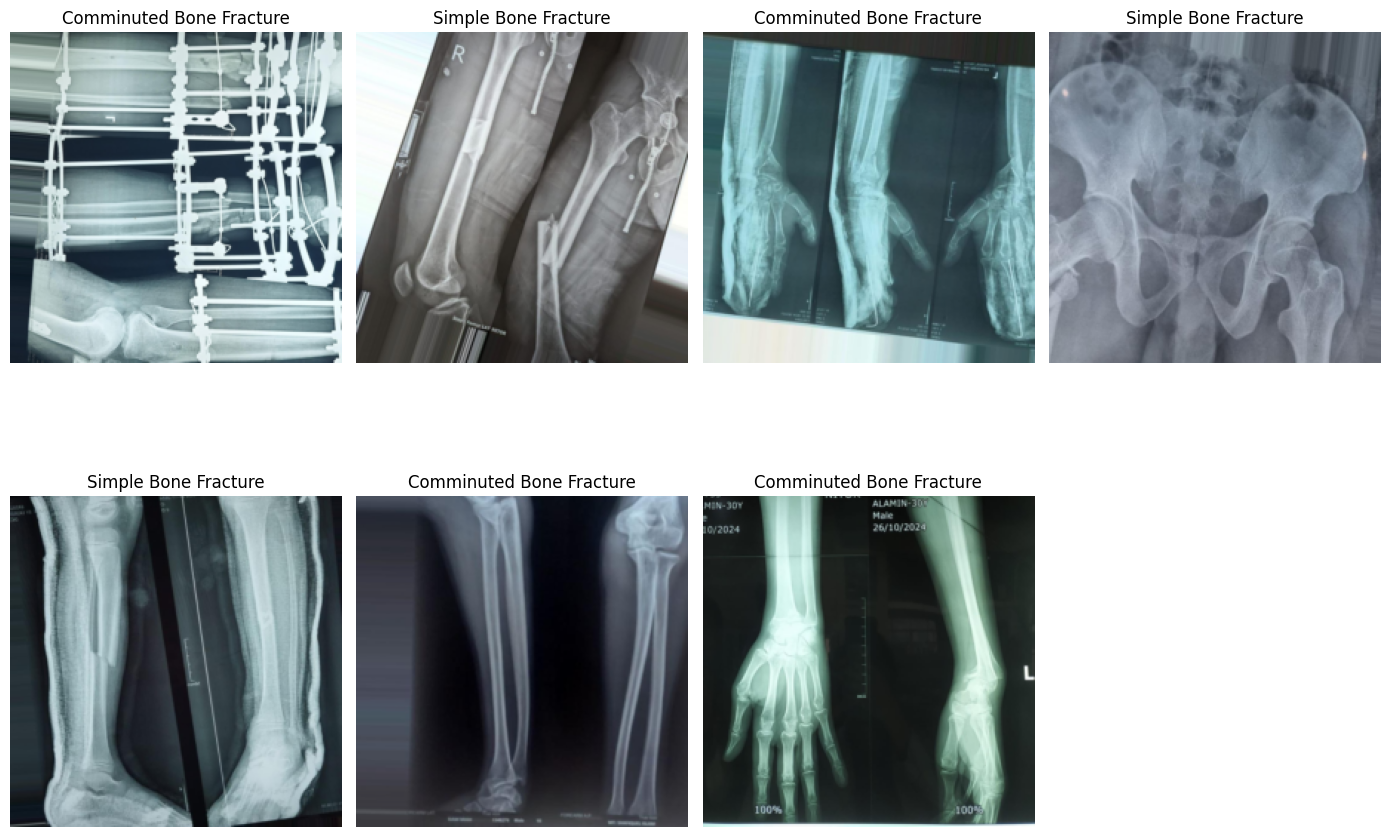

In [ ]:
# Helper function to denormalize and plot images
def imshow(image, title):
    image = image.numpy().transpose((1, 2, 0))
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    image = std * image + mean  # Denormalize
    image = image.clip(0, 1)    # Clip values to [0, 1]
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")  # Turn off axes

# Extract class names from the dataset
class_names = dataset.classes  # ['Comminuted Bone Fracture', 'Simple Bone Fracture']

# Display 7 images
data_iter = iter(dataloader)
images, labels = next(data_iter)
plt.figure(figsize=(14, 10))

for i in range(7):
    plt.subplot(2, 4, i + 1)
    imshow(images[i], title=class_names[labels[i]])
plt.tight_layout()
plt.show()

**Basic Comparison(Side-by-Side Images)**

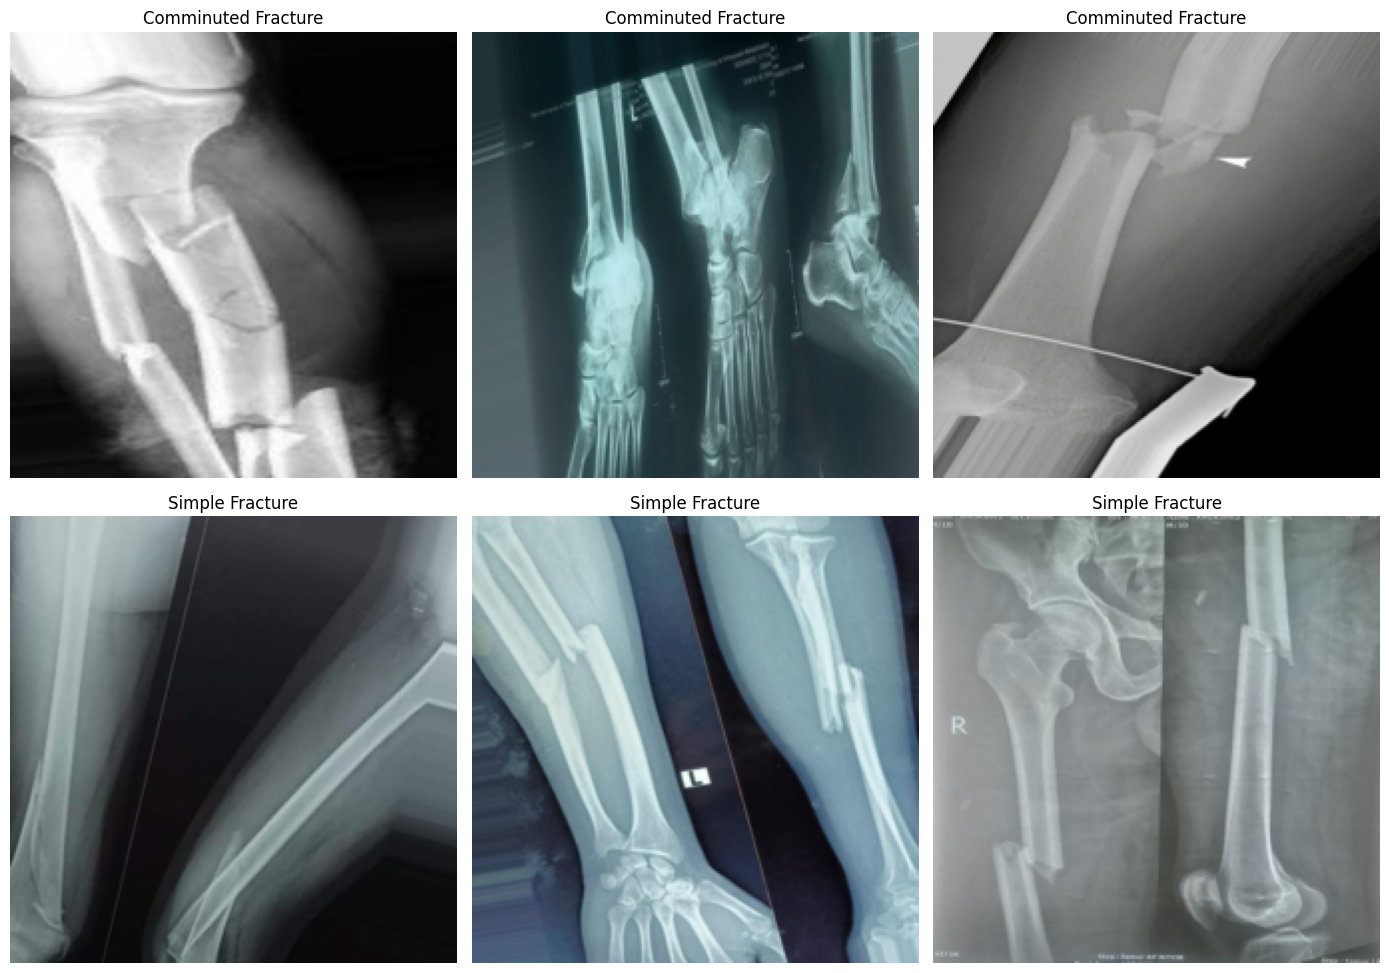

In [ ]:
# Helper function to denormalize and plot images
def imshow(image, title):
    image = image.numpy().transpose((1, 2, 0))
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    image = std * image + mean  # Denormalize
    image = image.clip(0, 1)    # Clip values to [0, 1]
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")  # Turn off axes

# Display comparison images
plt.figure(figsize=(14, 10))

# Extract images for both classes
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Find first images of each class
comminuted_idx = [i for i, label in enumerate(labels) if label == 0][:3]
simple_idx = [i for i, label in enumerate(labels) if label == 1][:3]

for i, idx in enumerate(comminuted_idx):
    plt.subplot(2, 3, i + 1)
    imshow(images[idx], title="Comminuted Fracture")

for i, idx in enumerate(simple_idx):
    plt.subplot(2, 3, i + 4)
    imshow(images[idx], title="Simple Fracture")

plt.tight_layout()
plt.show()

**Grid Comparison**

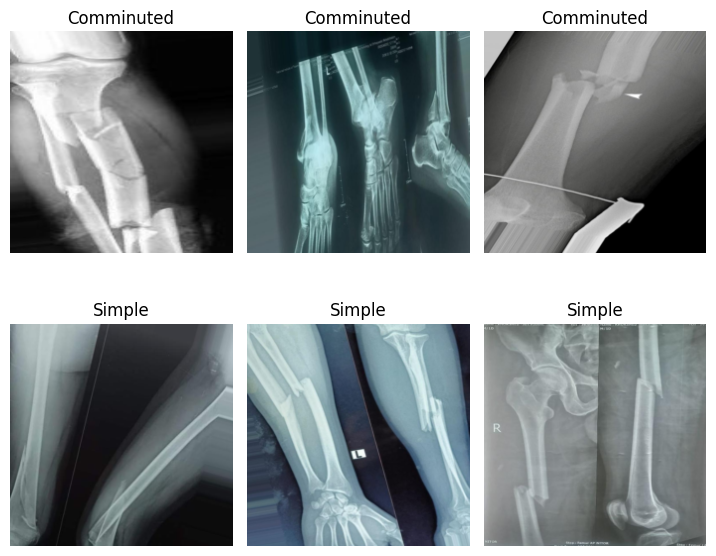

In [ ]:
# Limit to the number of available images for each class
num_comminuted = len(comminuted_idx)
num_simple = len(simple_idx)

# Define the number of images to display
num_images = min(5, num_comminuted, num_simple)

plt.figure(figsize=(12, 6))

for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    imshow(images[comminuted_idx[i]], title="Comminuted")

    plt.subplot(2, 5, i + 6)
    imshow(images[simple_idx[i]], title="Simple")

plt.tight_layout()
plt.show()


In [ ]:
# Check the number of examples per class
from collections import Counter
label_counts = Counter(labels.numpy())
print("Class distribution in this batch:", label_counts)

Class distribution in this batch: Counter({1: 22, 0: 10})


**Histogram Comparison**

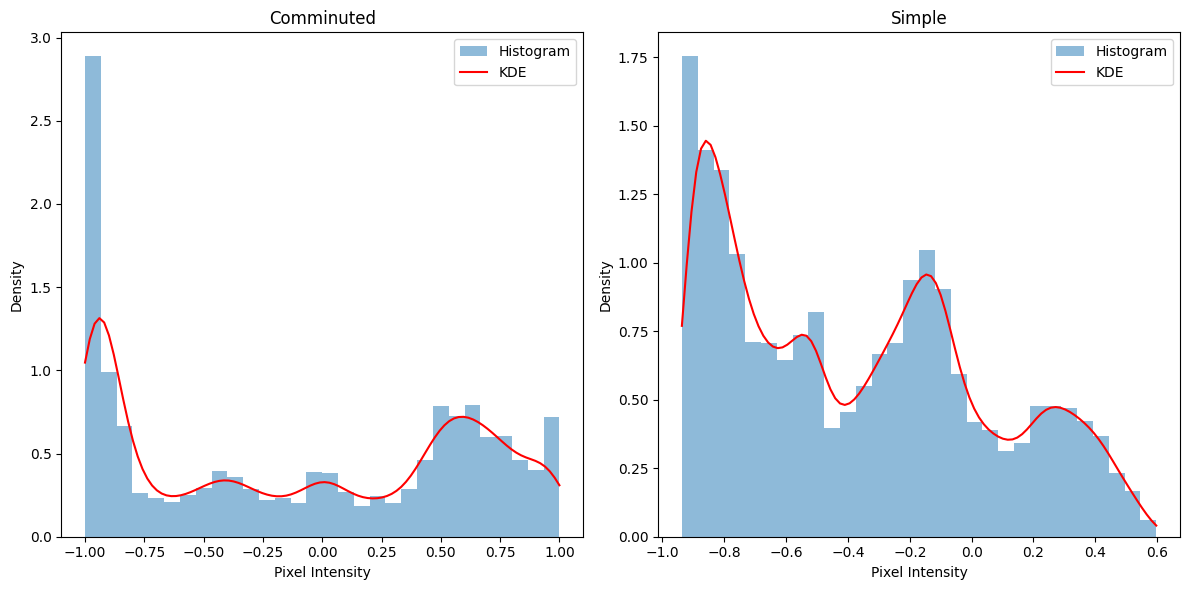

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, idx in enumerate([comminuted_idx[0], simple_idx[0]]):
    plt.subplot(1, 2, i + 1)

    # Extract the image and compute grayscale values
    image = images[idx].numpy().transpose((1, 2, 0))
    mean_image = image.mean(axis=2)  # Grayscale
    pixel_values = mean_image.ravel()

    # Plot histogram with density
    plt.hist(pixel_values, bins=30, alpha=0.5, density=True, label="Histogram")

    # Overlay KDE
    kde = gaussian_kde(pixel_values)
    x_vals = np.linspace(pixel_values.min(), pixel_values.max(), 100)
    plt.plot(x_vals, kde(x_vals), color='red', label="KDE")

    # Add labels and title
    plt.title("Comminuted" if i == 0 else "Simple")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()

**Annotation Comparison**

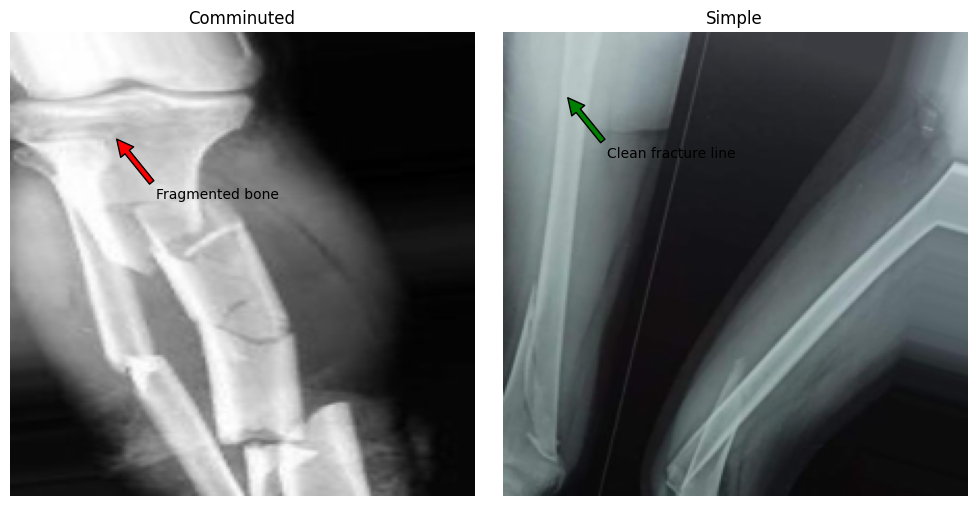

In [ ]:
from matplotlib.patches import FancyArrowPatch

plt.figure(figsize=(10, 5))

for i, idx in enumerate([comminuted_idx[0], simple_idx[0]]):
    plt.subplot(1, 2, i + 1)
    imshow(images[idx], title="Comminuted" if i == 0 else "Simple")
    if i == 0:
        plt.annotate("Fragmented bone", xy=(50, 50), xytext=(70, 80),
                     arrowprops=dict(facecolor='red', shrink=0.05))
    else:
        plt.annotate("Clean fracture line", xy=(30, 30), xytext=(50, 60),
                     arrowprops=dict(facecolor='green', shrink=0.05))

plt.tight_layout()
plt.show()

**Data Preprocessing and Loading**

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


original_dir = "/content/bone-fracturex-ray-simple-vs-comminuted-fractures/Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures/Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures/Bone Fracture/Bone Fracture/Orginal"
# Check if the directory exists
if not os.path.exists(original_dir):
    raise FileNotFoundError(f"Directory not found: {original_dir}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize with mean & std
])

# Load dataset
dataset = datasets.ImageFolder(original_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print class names
print("Classes:", dataset.classes)

# Print a few image paths and their labels for verification
for img, label in dataset:
    print(f"Image: {img.shape}, Label: {label}")
    break  # Show only one sample

Classes: ['Comminuted Bone Fracture', 'Simple Bone Fracture']
Image: torch.Size([3, 224, 224]), Label: 0


# **CNN Architecture**

**1.** Three convolutional layers (Conv2d with
increasing channels: **16 → 32 → 64**).

**2.** Max Pooling (MaxPool2d(2,2)) after each convolutional layer for downsampling.
**ReLU** activation for introducing **non-linearity**.

**3.** Two Fully Connected (FC) layers:


---


  a. fc1: **512** neurons.

---



  b. fc2: **2 neurons** (for binary classification: Simple    vs. Comminuted fracture).

---



**4.** A helper function (_calculate_fc_in_features)
to compute the number of features before feeding into FC layers dynamically.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        # Use a dummy forward pass to calculate the correct number of input features
        self._to_linear = None
        self._calculate_fc_in_features()
        self.fc1 = nn.Linear(self._to_linear, 512)  # Flattened layer
        self.fc2 = nn.Linear(512, 2)  # Output layer for 2 classes (Comminuted and Simple)

    def _calculate_fc_in_features(self):
        # Dummy input tensor to get the number of features after convolutions
        x = torch.zeros(1, 3, 224, 224)  # Assuming input size is (3, 224, 224)
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 -> ReLU -> Pool
        self._to_linear = x.numel()  # Get the total number of elements in the tensor

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 -> ReLU -> Pool

        x = x.view(-1, self._to_linear)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x

**Define the Loss Function and Optimizer**

*   Using Adam Optimizer
*   Cross Entropy fits the gap



In [ ]:

import torch

# Check if a CUDA-enabled GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Print the selected device for confirmation

# Initialize the model, loss function, and optimizer
model = SimpleCNN().to(device)  # Move the model to the selected device
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

Using device: cuda


# **Train the Model**

In [ ]:
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in dataloader:  # Make sure you use the correct DataLoader
        inputs, labels = inputs.cuda(), labels.cuda()  # Move to GPU

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Loss computation
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(dataloader)  # Use dataloader here
    accuracy = correct_preds / total_preds * 100

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/10], Loss: 0.7273, Accuracy: 57.05%
Epoch [2/10], Loss: 0.6262, Accuracy: 64.30%
Epoch [3/10], Loss: 0.5480, Accuracy: 70.43%
Epoch [4/10], Loss: 0.4719, Accuracy: 76.34%
Epoch [5/10], Loss: 0.3813, Accuracy: 81.42%
Epoch [6/10], Loss: 0.2961, Accuracy: 87.16%
Epoch [7/10], Loss: 0.1976, Accuracy: 92.41%
Epoch [8/10], Loss: 0.1162, Accuracy: 95.76%
Epoch [9/10], Loss: 0.0688, Accuracy: 98.07%
Epoch [10/10], Loss: 0.0238, Accuracy: 99.33%


# **Plot the Results**

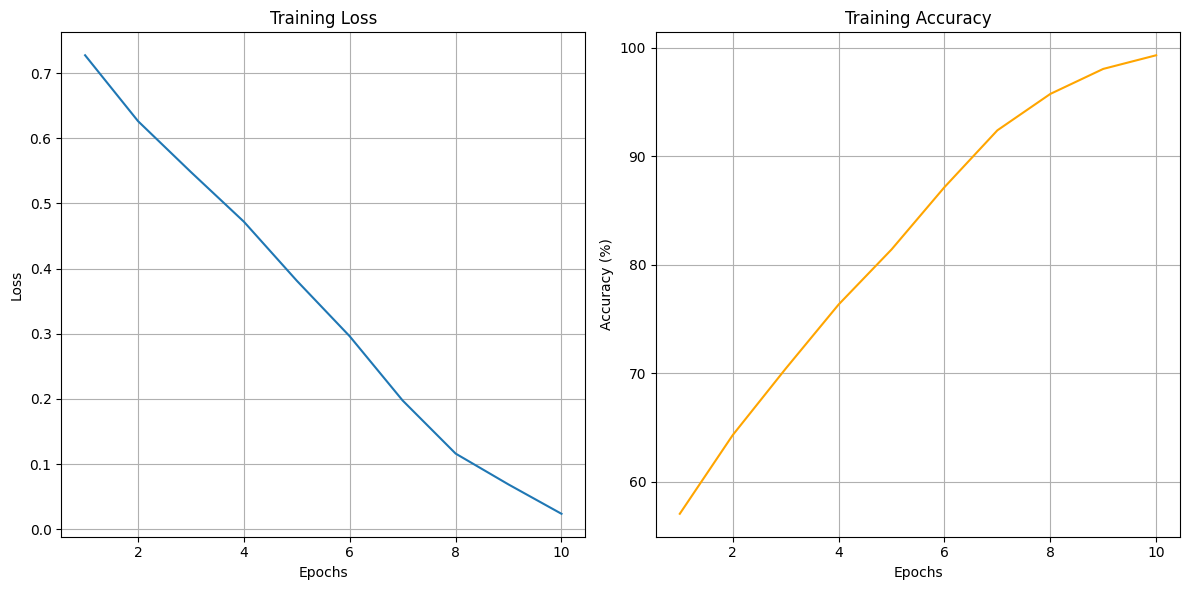

In [ ]:
# Plot Training Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

#**Testing the Model**

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the directory where the test data is located
original_dir = "/content/bone-fracturex-ray-simple-vs-comminuted-fractures/Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures/Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures/Bone Fracture/Bone Fracture/Orginal"


# Check if the directory exists
if not os.path.exists(original_dir):
    raise FileNotFoundError(f"Directory not found: {original_dir}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize with mean & std
])

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(original_dir, transform=transform)

# Create DataLoader
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# **Evaluate the Model and Plot Result**

Test Loss: 0.0089, Test Accuracy: 99.87%


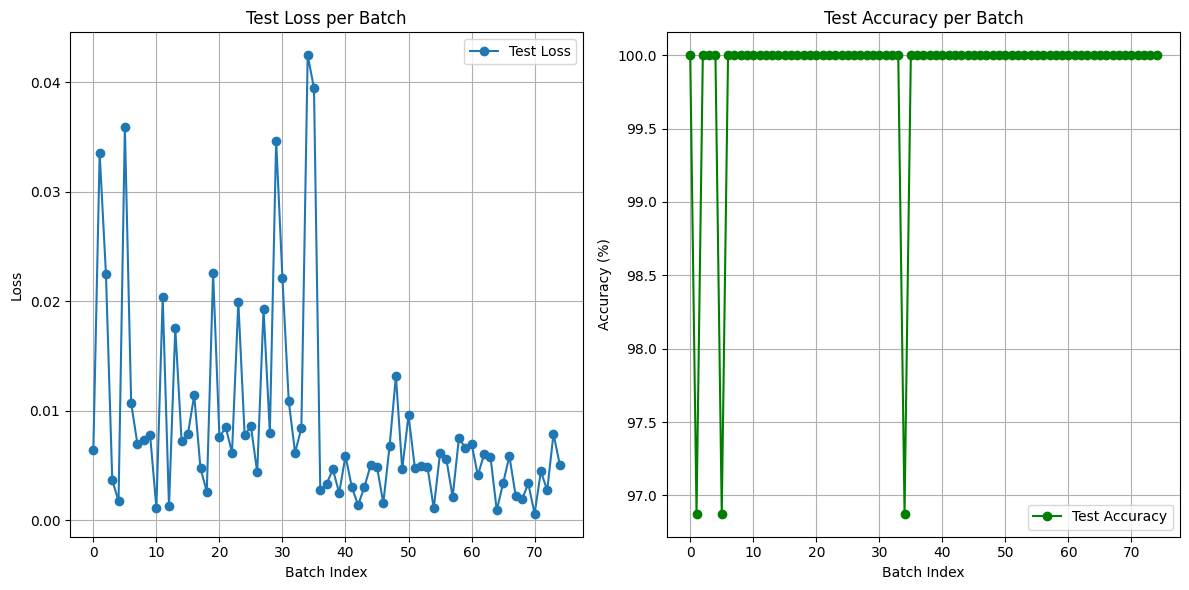

In [ ]:
# Now you can use this DataLoader in your evaluation loop
model.eval()  # Set model to evaluation mode
test_loss = 0.0
correct_preds = 0
total_preds = 0
losses = []
accuracies = []

with torch.no_grad():  # No gradients needed for evaluation
    for inputs, labels in test_dataloader:  # Iterate over the test dataloader
        inputs, labels = inputs.cuda(), labels.cuda()  # Move to GPU if necessary
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        # Collect loss and accuracy for each batch
        losses.append(loss.item())
        accuracies.append((predicted == labels).sum().item() / labels.size(0) * 100)

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = correct_preds / total_preds * 100

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plot test loss and accuracy
plt.figure(figsize=(12, 6))

# Plot test loss
plt.subplot(1, 2, 1)
plt.plot(range(len(losses)), losses, marker='o', label='Test Loss')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.title('Test Loss per Batch')
plt.legend()
plt.grid()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies)), accuracies, marker='o', label='Test Accuracy', color='green')
plt.xlabel('Batch Index')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Batch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

#Conclusion

The CNN model effectively classifies bone fractures with **high accuracy (99.87%)**.

The model has the real-world potential in medical diagnostics, telemedicine, and automated screening.